In [1]:
import tensorflow as tf
import numpy as np
import deepxde as dde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [13]:
# Set the data type 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi,dtype=DTYPE)

def fun_u_0(x):
    return tf.sin( pi * x)

def fun_u_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1),dtype = DTYPE)

def f(x,t):
    return tf.constant(np.pi,dtype='float32')*tf.exp(-2*t)*tf.sin(np.pi*x)*tf.cos(np.pi*x)

def residual(u,u_t,u_x,u_xx, l1, x,t):
    
    f_val = f(x,t)
    f_u = u_t + u*u_x- l1*u_xx - f_val

    return f_u

class PhysicsInformedNN:
    def __init__(self, lb, ub, layers, u0, x0, X):

        self.lambda1 = 1/tf.constant(np.power(np.pi,2),dtype='float32')
        self.lb = lb
        self.ub = ub
                
        self.layers = layers

        self.u0 = u0
        self.X0 = x0

        self.X = X

        self.model = self.initialize_NN(layers)

    def initialize_NN(self,layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(layers[0]))
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x-self.lb)/(self.ub-self.lb)-1.0)
        model.add(scaling_layer)
        num_layers = len(layers)
        for i in range(1,num_layers-2):
            model.add(tf.keras.layers.Dense(layers[i],
                                            activation=tf.keras.activations.get('tanh'),
                                            kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(layers[-1]))

        return model
    

    def loss(self, X, X0, u0):
        u_pred = self.model(X0)
        
        loss = tf.reduce_mean(tf.square(u0-u_pred))

        r1 = self.get_residual(X)

        phi_ru = tf.reduce_mean(tf.square(r1))

        loss += phi_ru

        return loss
    
    def get_residual(self,X):
        with tf.GradientTape(persistent=True) as tape:
            x = X[:,0:1]
            t = X[:,1:2]

            tape.watch(x)
            tape.watch(t)

            u = self.model(tf.stack([x[:,0],t[:,0]], axis=1))


            u_t = tape.gradient(u,t)
            u_x = tape.gradient(u,x)
            u_xx = tape.gradient(u_x,x)


        del tape
        
        l1 = self.lambda1
        f_u = residual(u,u_t,u_x,u_xx,l1, x, t)

        return f_u
    
    def loss_gradient(self,X,X0,u0, v0):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss(self, X, X0, u0, v0)
            g = tape.gradient(loss, self.model.trainable_variables)

        del tape
        return loss, g

    # def optimization_step(self, cor=50, tol=1.0  * np.finfo(float).eps,  iter=50000, fun=50000, ls=50):
    #     def time_step():
    #         loss = self.loss(self.X, self.X0, self.u0)
    #         return loss
    #     variables = self.model.trainable_variables
    #     dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
    #     dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    #     return loss


In [15]:
import scipy

In [16]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 2.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0 , t_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, t_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([ x_r,t_r], axis=1)

# Collect boundary and inital data in lists
X_data = tf.concat([X_0, X_b],0)
u_data = tf.concat([u_0, u_b],0)


In [17]:
model = PhysicsInformedNN(xmin, xmax, layers, u_data, X_data, X_r)

In [18]:
def time_step():
        loss = model.loss(model.X, model.X0, model.u0)
        return loss

In [19]:
variables = model.model.trainable_variables

In [10]:
cor=50
tol=1.0  * np.finfo(float).eps
iter=50000
fun=50000
ls=50

In [20]:
dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)

In [21]:
dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=False>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=True>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=2290>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=6293>, position=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([0.18730332, 0.07460342, 0.01832494, ..., 0.57906175, 0.13960277,
       0.05992305], dtype=float32)>, objective_value=<tf.Tensor: shape=(), dtype=float32, numpy=4.268424e-06>, objective_gradient=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([-1.6042730e-05,  4.0220330e-06, -7.2791026e-06, ...,
       -6.7583460e-07, -7.1092509e-06, -9.2702976e-06], dtype=float32)>, position_deltas=<tf.Tensor: shape=(50, 2601), dtype=float32, numpy=
array([[ 8.1211329e-06,  5.6542456e-05, -8.3930790e-06, ...,
        -2.3007393e-05,  1.8849969e-05, -1.4419854e-04],
       [-2.1755695e-05, -4.3410063e-04,  2.0117126e-04, ...,
         1.6558170e-04, -2.1651387e-05, 

In [22]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

In [23]:
x = X_r[:,0]
y = X_r[:,1]
z = model.model(model.X)

In [24]:
x = np.arange(xmin,xmin,0.01)
t = np.arange(tmin,tmax,0.01)
x, t = np.meshgrid(x, t)


In [25]:
x = np.arange(-1,1,0.01)
t = np.arange(0,1,0.01)
x,t  = np.meshgrid(x,t)

In [62]:
xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]))
tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
X = tf.concat([xn,tn],1)

In [63]:
z = model.model(X)
z = z.numpy()
z = z.reshape(x.shape)

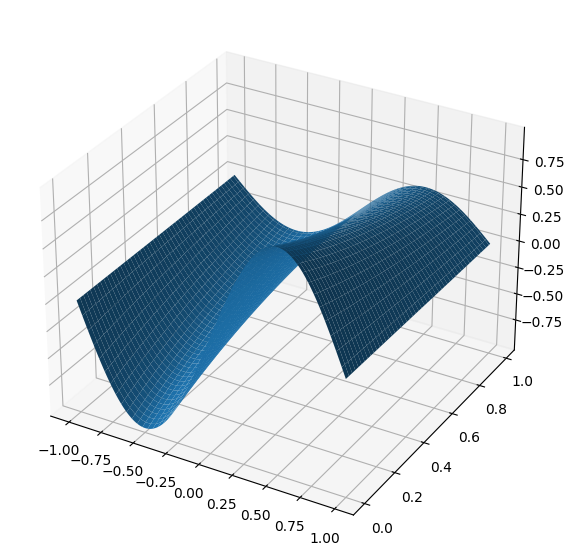

In [29]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, z)

In [64]:
z2 = np.sin(np.pi*x)*np.exp(-t)

In [69]:
np.sum(np.power(z2-z,2))

0.00408879614525168

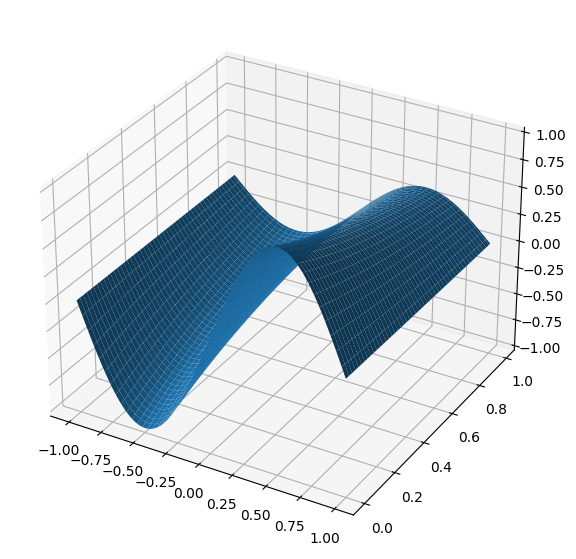

In [34]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, z)

In [51]:
xp = x[1,:]
tp = t[0,:]

xn = tf.convert_to_tensor(np.transpose([np.ravel(xp)]))
tn = tf.convert_to_tensor(np.transpose([np.ravel(tp)]))
X = tf.concat([xn,tn],1)

In [52]:
z = model.model(X)
z = z.numpy()
z = z.reshape(xp.shape)
z2 = np.sin(np.pi*xp)*np.exp(-tp)

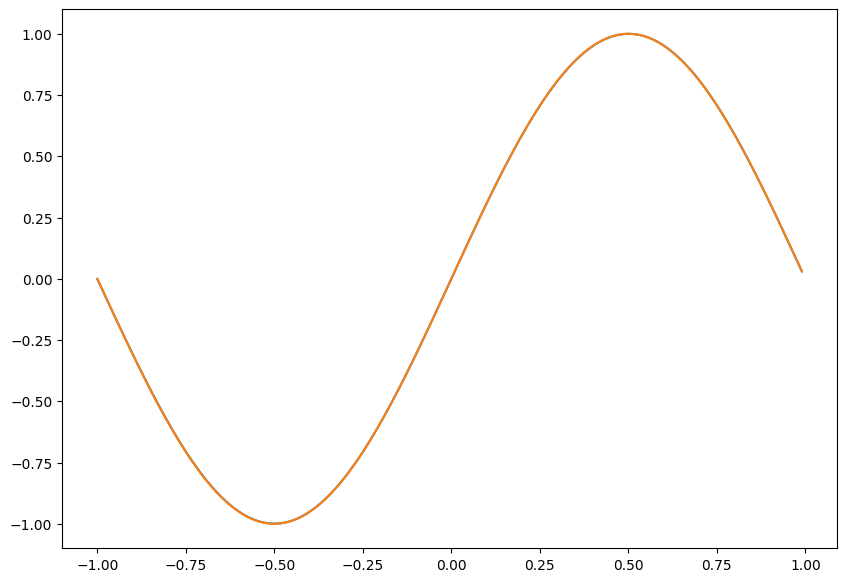

In [53]:
fig = plt.figure(figsize = (10, 7))
plt.plot(xp,z)
plt.plot(xp,z2)

In [ ]:
model